<a href="https://colab.research.google.com/github/ansilpm/FINAL-SUBMISSION/blob/main/final_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FINAL SUBMISSION OF MY PROJECT


step 1

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
farzadnekouei_trash_type_image_dataset_path = kagglehub.dataset_download('farzadnekouei/trash-type-image-dataset')

print('Data source import complete.')


Data source import complete.


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

First, I will bring in the libraries I need for this project:

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

<a id="Dataset_Analysis"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 2 | Dataset Analysis</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [3]:
import os
from PIL import Image

# Define the path where our dataset is stored
# Update dataset_path to point to the directory containing image folders
dataset_path = r'/kaggle/input/trash-type-image-dataset/TrashType_Image_Dataset'

# Retrieve the names of all folders (representing trash types) within the dataset directory
garbage_types = os.listdir(dataset_path)

# Set to store unique image dimensions for the entire dataset
all_dimensions_set = set()

# Iterate over each trash type (folder) to process images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Display the count of images in the current folder
        num_images = len(image_files)
        print(f"{garbage_type} folder contains {num_images} images.")

        # Loop over each image to check its dimensions
        for image_file in image_files:
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                # Extract the width, height, and channels (color depth) of the image and add to the dimensions set
                width, height = img.size
                channels = len(img.getbands())
                all_dimensions_set.add((width, height, channels))

# Determine if all images in the entore dataset have the same dimensions
if len(all_dimensions_set) == 1:
    width, height, channel = all_dimensions_set.pop()
    print(f"\nAll images in the dataset have the same dimensions: {width}x{height} with {channels} color channels.")
else:
    print("\nThe images in the dataset have different dimensions or color channels.")

metal folder contains 410 images.
glass folder contains 501 images.
paper folder contains 594 images.
trash folder contains 137 images.
cardboard folder contains 403 images.
plastic folder contains 482 images.

All images in the dataset have the same dimensions: 512x384 with 3 color channels.


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📊 Inference on Class Imbalance</font></h2>


The "Garbage Image Dataset" reveals a noticeable imbalance in the distribution of its image categories:

- **cardboard**: 403 images
- **glass**: 501 images
- **metal**: 410 images
- **paper**: 594 images
- **plastic**: 482 images
- **trash**: 137 images

Imagine teaching a child to identify animals by showing them 95 pictures of cats and just 5 pictures of dogs. They'd probably start to think most pets are cats due to the sheer number of cat images they've seen. Similarly, in our dataset, a machine learning model might become adept at identifying "paper" but may not be as skilled with "trash" because of the fewer examples.

This can lead to:

1️⃣ **Bias**: The model might lean towards predicting "paper" often because it's seen it more during training.
    
    
2️⃣ **Generalization Issues**: If we deploy our model in a real-world scenario where "trash" items are just as common as "paper" items, our model might not perform well.

    
3️⃣ **Accuracy Deception**: The model could seem highly accurate if it keeps guessing the dominant class, but it might be weak in detecting underrepresented classes like "trash".

To create an efficient classifier, addressing this imbalance is crucial.

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's visually explore the images from each garbage category:

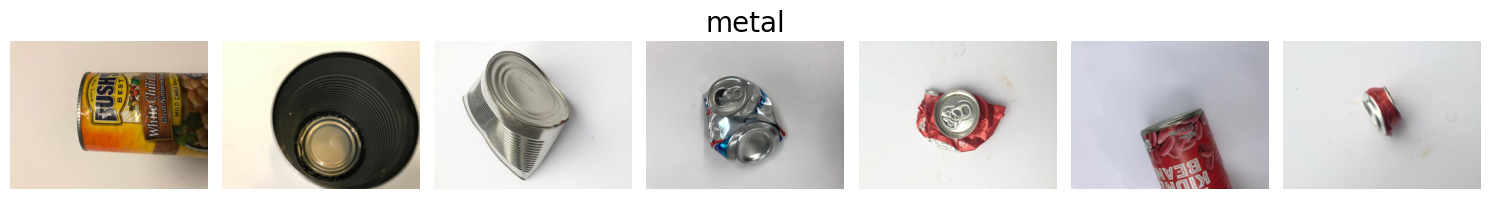

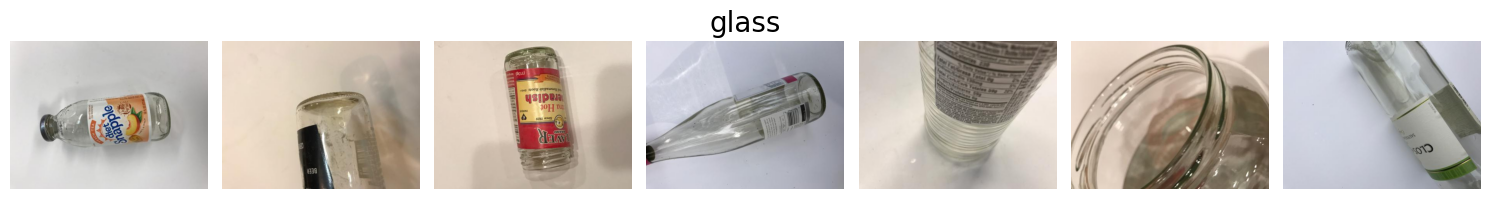

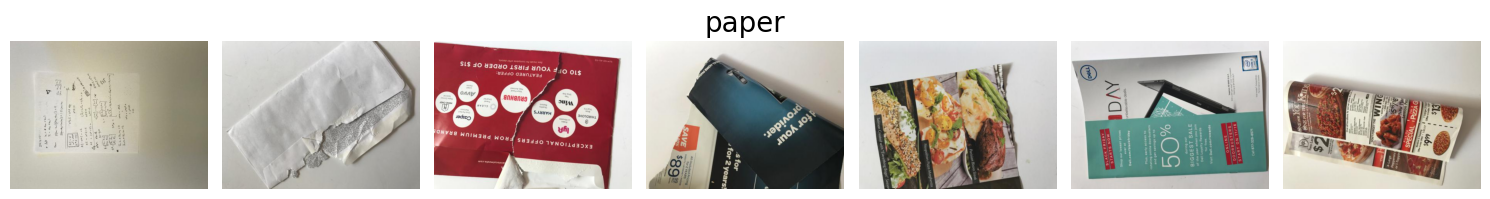

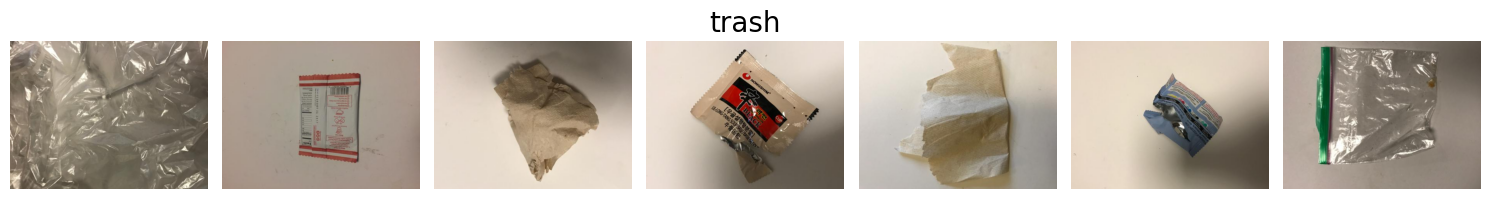

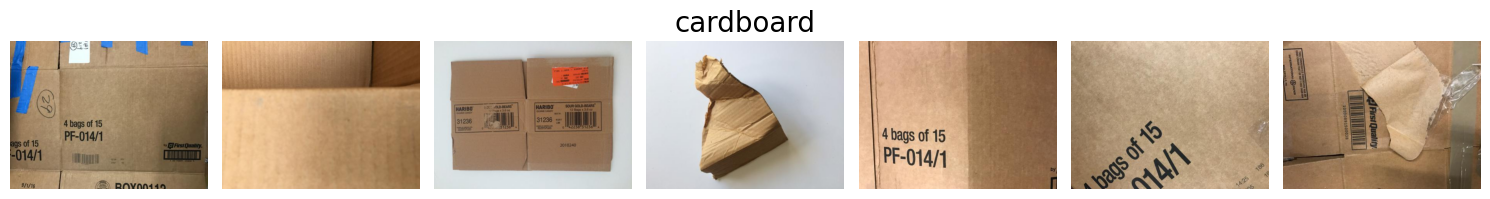

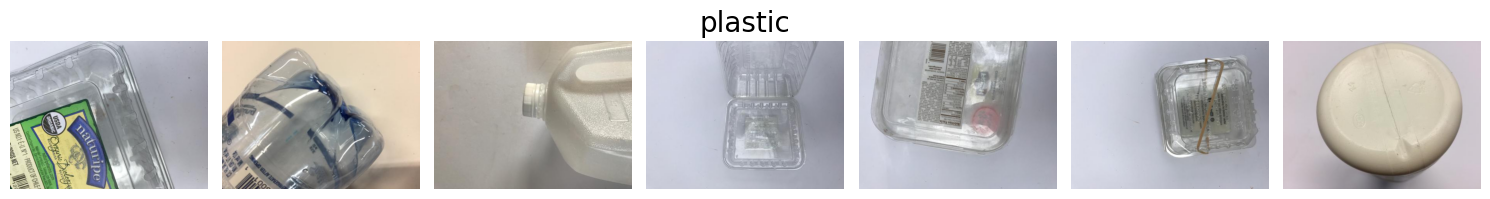

In [4]:
# Iterate over each trash type (folder) to display images
for garbage_type in garbage_types:
    folder_path = os.path.join(dataset_path, garbage_type)

    # Verify that the current item is a directory
    if os.path.isdir(folder_path):
        image_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg', 'jpeg'))]

        # Select the first 10 images
        image_files = image_files[:7]

        # Set up subplots
        fig, axs = plt.subplots(1, 7, figsize=(15, 2))

        for i, image_file in enumerate(image_files):
            image_path = os.path.join(folder_path, image_file)
            with Image.open(image_path) as img:
                axs[i].imshow(img)
                axs[i].axis('off')

        plt.tight_layout()
        fig.suptitle(garbage_type, fontsize=20, y=1.03)
        plt.show()

<a id="Dataset_Preparation"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 3 | Dataset Preparation</p>
⬆️ [Tabel of Contents](#contents_tabel)

<a id="Centralize_Dataset"></a>
# <b><span style='color:darkturquoise'>Step 3.1 |</span><span style='color:royalblue'> Centralize Dataset Information</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

### 🔍 <span style="color:royalblue">Concern:</span>
We have all our images scattered across multiple folders, one for each garbage class. We need a unified view of the data for easy manipulation.

### 🛠️ <span style="color:royalblue">Strategy:</span>
Create a DataFrame that contains file paths and corresponding labels.

In [5]:
# Initialize an empty list to store image file paths and their respective labels
data = []

# Loop through each garbage type and collect its images' file paths
for garbage_type in garbage_types:
    # Check if the item is a directory before listing files
    folder_path = os.path.join(dataset_path, garbage_type)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            # Append the image file path and its trash type (as a label) to the data list
            data.append((os.path.join(folder_path, file), garbage_type))

# Convert the collected data into a DataFrame
df = pd.DataFrame(data, columns=['filepath', 'label'])

# Display the first few entries of the DataFrame
display(df.head())

,filepath,label
0,/kaggle/input/trash-type-image-dataset/TrashTy...,metal
1,/kaggle/input/trash-type-image-dataset/TrashTy...,metal
2,/kaggle/input/trash-type-image-dataset/TrashTy...,metal
3,/kaggle/input/trash-type-image-dataset/TrashTy...,metal
4,/kaggle/input/trash-type-image-dataset/TrashTy...,metal


<a id="Splitting_Dataset"></a>
# <b><span style='color:darkturquoise'>Step 3.2 |</span><span style='color:royalblue'> Stratified Data Splitting: Train & Validation</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
### 🔍 <span style="color:royalblue">Concern:</span>
To ensure our train and validation sets represent all garbage classes well, and to avoid potential biases associated with the order of images, we need the sets to have a similar distribution of classes as the whole dataset and also be shuffled.

### 🛠️ <span style="color:royalblue">Strategy:</span>
Employ stratified sampling through `train_test_split`, which inherently shuffles and divides the DataFrame while maintaining a consistent distribution of classes.

In [6]:
# Split with stratification
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Print the number of images in each set
print(f"Number of images in the training set: {len(train_df)}")
print(f"Number of images in the validation set: {len(val_df)}")

Number of images in the training set: 2021
Number of images in the validation set: 506


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's verify that the distributions in the training and validation sets closely mirror the overall distribution:

In [7]:
# 1. Class distribution in the entire dataset
overall_distribution = df['label'].value_counts(normalize=True) * 100

# 2. Class distribution in the training set
train_distribution = train_df['label'].value_counts(normalize=True) * 100

# 3. Class distribution in the validation set
val_distribution = val_df['label'].value_counts(normalize=True) * 100

print("Class distribution in the entire dataset:\n")
print(overall_distribution.round(2))
print('-'*40)

print("\nClass distribution in the training set:\n")
print(train_distribution.round(2))
print('-'*40)

print("\nClass distribution in the validation set:\n")
print(val_distribution.round(2))

Class distribution in the entire dataset:

label
paper        23.51
glass        19.83
plastic      19.07
metal        16.22
cardboard    15.95
trash         5.42
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the training set:

label
paper        23.50
glass        19.84
plastic      19.05
metal        16.23
cardboard    15.93
trash         5.44
Name: proportion, dtype: float64
----------------------------------------

Class distribution in the validation set:

label
paper        23.52
glass        19.76
plastic      19.17
metal        16.21
cardboard    16.01
trash         5.34
Name: proportion, dtype: float64


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📊 Inference on Stratification Effectiveness</font></h2>

The class distributions in both the training and validation sets closely mirror the overall distribution in the entire dataset, indicating that stratification during the split was successful.

<a id="Data_Augmentation"></a>
# <b><span style='color:darkturquoise'>Step 3.3 |</span><span style='color:royalblue'> Data Augmentation & Rescaling</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
### 🔍 <span style="color:royalblue">Concern:</span>
- We have limited images, so we risk overfitting.
- Neural networks work better with input values between 0 and 1, but our images have pixel values between 0 and 255.

### 🛠️ <span style="color:royalblue">Strategy:</span>
- Augment the training images to artificially increase dataset size.
- Rescale both training and validation images for better network performance.

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Note on Data Augmentation in Validation Set</font></h2>

__Data augmentation__ is a technique primarily used to expand the training dataset in order to improve the model's capacity to generalize and avoid overfitting. The primary objective is to introduce variability and mimic potential real-world distortions in the training images without actually collecting more data.

On the other hand, the validation set's role is to provide an unbiased evaluation of a model's performance on unseen data. Thus, we want the validation data to remain consistent throughout the model's training process to ensure that our evaluations are stable and reproducible. Applying augmentations to the validation set would introduce random variability in the evaluation metrics across different epochs, making it harder to determine whether changes in the model's performance are due to the model's learning or just the variability introduced by augmentations.

Therefore, to maintain a consistent and clear evaluation benchmark, I refrain from applying data augmentation to the validation set, using only rescaling to ensure the pixel values are in a similar range as the augmented training images.

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Designing Data Augmentation for Trash Classification</font></h2>

Based on the dataset, here are some observations regarding the potential data augmentation techniques:

<h3 align="left"><font color=royalblue>Suitable Transformations:</font></h3>

- __Rescaling__: Necessary to normalize pixel values between 0 and 1.
- __Rotation__: Captures objects in various orientations.
- __Width and Height Shift__: Models minor positional changes.
- __Zoom__: Simulates different object distances.
- __Flip__: Captures different horizontal or vertical orientations.
- __Shear__: Provides a skewed perspective of images.
- __Brightness Adjustment__: Adapts images to diverse lighting conditions.
- __Channel Shift__: Alters colors for added variety.
- __Fill Mode__: Addresses missing pixel values.

In [8]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

<a id="Generate_Batch"></a>
# <b><span style='color:darkturquoise'>Step 3.4 |</span><span style='color:royalblue'> Generating Batches of Images</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
### 🔍 <span style="color:royalblue">Concern:</span>
- We can't load all images at once due to memory constraints.
- We want to benefit from the DataFrame format to feed our images into our model.
- Most CNN architectures often perform better with square images.
- We aim to avoid manual one-hot encoding of labels.
- Ensuring consistent ordering and reproducibility during training.

### 🛠️ <span style="color:royalblue">Strategy:</span>
- Use the `flow_from_dataframe` method to generate batches of images and labels directly from our DataFrame.
- Rescale images to 384x384 to maintain a square shape, aligning with the design preferences of CNNs.
- Leverage the initial shuffling done through `train_test_split` to randomize data order, eliminating the need for additional shuffling in the generators.
- Use a seed (`seed=0`) during data augmentation to ensure reproducibility of transformations across runs.

In [9]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

Found 2021 validated image filenames belonging to 6 classes.
Found 506 validated image filenames belonging to 6 classes.


In [10]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16



# Create the new model with higher dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
x = Dense(6, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

from tensorflow.keras.optimizers import Adam
try:
    from tensorflow_addons.optimizers import AdamW
    optimizer = AdamW(learning_rate=0.0001, weight_decay=1e-5)
except ImportError:
    optimizer = Adam(learning_rate=0.0001)

transfer_resnet50_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model

# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

# Freeze the layers up to conv4_block6_out (layer 142)
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

# Create the new model with higher dropout
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.6)(x)
x = Dense(6, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model initially with a higher learning rate
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Fine-tune more layers after initial training
for layer in base_model.layers[130:]:
    layer.trainable = True

# Re-compile with lower LR for fine-tuning
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<a id="Dataset_Imbalances"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 4 | Addressing Dataset Imbalances</p>
⬆️ [Tabel of Contents](#contents_tabel)

In [13]:

# Improved augmentation with more variety
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8,1.2],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)


In [14]:
train_generator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Improved callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

callbacks = [checkpoint, reduce_lr, early_stopping]

In [18]:
from sklearn.utils import compute_class_weight

# Compute class weights
class_labels = np.unique(train_df['label'])
weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_df['label'])

# Convert the computed weights to a dictionary for passing to model training
# Ensure the class indices are populated by first accessing the generator
train_generator.class_indices
class_weights = dict(zip(train_generator.class_indices.values(), weights))
print("Computed class weights:", class_weights)

Computed class weights: {0: np.float64(1.0460662525879918), 1: np.float64(0.8399833748960931), 2: np.float64(1.026930894308943), 3: np.float64(0.7091228070175438), 4: np.float64(0.8748917748917749), 5: np.float64(3.062121212121212)}


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Understanding Class Label Mapping in ImageDataGenerator:</font></h2>

When we create a generator using __`flow_from_dataframe`__ with the __`class_mode='categorical'`__ setting, the generator internally maps each unique class label in our `y_col` (in this case, the "label" column of __`train_df`__) to a unique integer. This mapping is done in alphabetical order, which means:

- '__cardboard__' is mapped to __0__
- '__glass__' is mapped to __1__
- '__metal__' is mapped to __2__
- '__paper__' is mapped to __3__
- '__plastic__' is mapped to __4__
- '__trash__' is mapped to __5__

This mapping is stored in the __`train_generator.class_indices`__ dictionary. The keys of this dictionary are the class labels (e.g., 'cardboard', 'glass', etc.), and the corresponding values are the mapped integers (e.g., 0, 1, etc.).

This mapping ensures that when we're using one-hot encoding, the correct position in the one-hot encoded vector corresponds to the appropriate class. For example, the one-hot encoded vector for 'cardboard' would be __`[1, 0, 0, 0, 0, 0]`__.

When we computed the __`class_weights`__, we used this mapping to ensure the weights correspond correctly to the one-hot encoded labels during training.

<a id="Resnet50"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 5 | ResNet50 Built from Scratch</p>
⬆️ [Tabel of Contents](#contents_tabel)

<a id="Define_Scratch"></a>
# <b><span style='color:darkturquoise'>Step 5.1 |</span><span style='color:royalblue'> Defining the ResNet50 Architecture from Scratch</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

For this phase of our project, I've chosen to work with the __ResNet__ architecture, specifically its famous variant, __ResNet50__. The standout feature of ResNet architectures is the incorporation of "__skip__" or "__shortcut__" connections. These ingenious connections allow layers to skip intermediate layers and connect directly to subsequent ones. This design is pivotal in addressing the __vanishing gradient__ problem, enabling the efficient training of much deeper neural networks than previously possible.

To build our ResNet50 model, we first lay the foundation by implementing its core component—the '__Residual Block__'. Here's a representation of this essential block:

<img src="https://github.com/FarzadNekouee/Garbage_Classification_ResNet50_Scratch_to_Transfer-Learning/blob/master/images/Residual_Block.png?raw=true" width="2400">

In [20]:
def residual_block(X, kernel_size, filters, reduce=False, stride=2):
    """
    Implement a residual block for ResNet architectures.

    Arguments:
    X           -- input tensor of shape (m, height, width, channels)
    kernel_size -- integer, kernel size of the middle convolutional layer in the main path
    filters     -- python list of integers, defining the number of filters in the CONV layers of the main path
    reduce      -- boolean, whether to reduce the spatial dimensions and increase depth;
                    if True, applies 1x1 CONV layer to the shortcut path.
    stride      -- integer, strides for the convolutional layer

    Returns:
    X           -- output of the identity block, tensor of shape (height, width, channels)
    """

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We will need this later to add back to the main path.
    X_shortcut = X

    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (stride,stride), padding = 'valid', kernel_initializer='he_normal')(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3)(X_shortcut)
    else:
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
        X = BatchNormalization(axis = 3)(X)
        X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (kernel_size, kernel_size), strides = (1,1), padding = 'same', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal')(X)
    X = BatchNormalization(axis = 3)(X)

    # Final step: Add shortcut value to main path, and pass it through a ReLU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

<h2 align="left"><font color=royalblue>📌 Understanding the Residual Block:</font></h2>
    
- To adjust the depth of the feature map, we employ a 1x1 CONV layer on the shortcut path (when `reduce=True`). This also allows us to modify the height and width of the feature map as well. However, to ensure consistent sizes when adding the feature maps from the main and shortcut paths at the end of the block, the first 1x1 convolution in the main path and the 1x1 convolution in the shortcut path must share the same stride.


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

Now let's build our ResNet50 architecture as a function that takes `input_shape` and `classes` as arguments and outputs the model:

In [21]:
def ResNet_50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Block 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Block 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Block 3
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Block 4
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Block 5
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)

    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

With the intricate design of ResNet50 and our small dataset, the model tends to overfit on the training data. To address this, I've tailored the ResNet architecture by introducing a Dropout layer after the `GlobalAveragePooling2D` layer:

In [22]:
def Modified_ResNet50(input_shape, classes):
    """
    Arguments:
    input_shape -- tuple shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), kernel_initializer='he_normal')(X_input)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = residual_block(X, 3, [64, 64, 256], reduce=True, stride=1)
    X = residual_block(X, 3, [64, 64, 256])
    X = residual_block(X, 3, [64, 64, 256])

    # Stage 3
    X = residual_block(X, 3, [128, 128, 512], reduce=True, stride=2)
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])
    X = residual_block(X, 3, [128, 128, 512])

    # Stage 4
    X = residual_block(X, 3, [256, 256, 1024], reduce=True, stride=2)
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])
    X = residual_block(X, 3, [256, 256, 1024])

    # Stage 5
    X = residual_block(X, 3, [512, 512, 2048], reduce=True, stride=2)
    X = residual_block(X, 3, [512, 512, 2048])
    X = residual_block(X, 3, [512, 512, 2048])

    # Global Average Pooling to reduce spatial dimensions
    X = GlobalAveragePooling2D()(X)

    # Add Dropout to prevent overfitting
    X = Dropout(0.5)(X)

    # Fully Connected Layer for classification
    X = Dense(classes, activation='softmax')(X)

    # Create the model
    model = Model(inputs = X_input, outputs = X, name='Modified_ResNet50')

    return model

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Afterward, I am going to initialize our modified ResNet50 model:

In [23]:
# Define the shape of the input images and number of classes
input_shape = (384, 384, 3)
num_classes = 6

# Initialize the modified ResNet50 model with the specified parameters
modified_resnet50_model = Modified_ResNet50(input_shape=input_shape, classes=num_classes)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
Now, let's visualize the architecture of our model:

In [24]:
try:
    plot_model(modified_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)
except Exception as e:
    print(f"An error occurred while trying to plot the model: {e}")
    print("This error is likely due to graphviz not being installed or configured correctly.")
    print("You might need to install graphviz on your system for plot_model to work.")

"dot" with args ['-Tpng', '/tmp/tmpy63vcimt/tmpgn0kdgy1'] returned code: -6

stdout, stderr:
 b''
b"failed at node 10270[1]\ndot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.\n"

An error occurred while trying to plot the model: "dot" with args ['-Tpng', '/tmp/tmpy63vcimt/tmpgn0kdgy1'] returned code: -6
This error is likely due to graphviz not being installed or configured correctly.
You might need to install graphviz on your system for plot_model to work.


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Finally, lets examine our model summary to understand the number of parameters involved:

In [25]:
modified_resnet50_model.summary()

Model: "Modified_ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 189, 189,  │      9,472 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 189, 189,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 189, 189,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 94, 94,    │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 94, 94,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 94, 94,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 94, 94,    │     36,928 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 94, 94,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 94, 94,    │     16,640 │ activation_2[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 94, 94,    │     16,640 │ max_pooling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 94, 94,    │      1,024 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 94, 94,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 94, 94,    │          0 │ add[0][0]       

 Total params: 23,600,006 (90.03 MB)

 Trainable params: 23,546,886 (89.82 MB)

 Non-trainable params: 53,120 (207.50 KB)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

Our model comprises approximately 23.5 million trainable parameters.

<a id="Train_Scratch"></a>
# <b><span style='color:darkturquoise'>Step 5.2 |</span><span style='color:royalblue'> Training the Defined ResNet50 Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>📝 Preparing the Model for Training:</font></h2>
    
Now, I am going to get our model prepared for training:
    
- I will choose the `adam` optimizer, known for adapting learning rates throughout training.
- I will use the `categorical_crossentropy` loss function, suitable for multi-class classification tasks.
- I will select `accuracy` as a metric for simplicity. Given our dataset's imbalance, I will utilize additional metrics to better assess our model performance later.

In [26]:
modified_resnet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🛠️ Enhancing Training with Callbacks:</font></h2>
    
Next, I will define two key callbacks to enhance and monitor our training process:

1️⃣ **ReduceLROnPlateau**:
   - The `ReduceLROnPlateau` callback is used to reduce the learning rate by half (factor=0.5) whenever the validation loss does not improve for 15 consecutive epochs. This helps to adjust the learning rate dynamically, allowing the model to get closer to the global minimum of the loss function when progress has plateaued. This strategy can improve the convergence of the training process.

    
2️⃣ **EarlyStopping**:
   - The `EarlyStopping` callback is employed to monitor the validation loss and halt the training process when there hasn't been any improvement for 30 epochs, ensuring that the model doesn't waste computational resources and time. Furthermore, this callback restores the best weights from the training process, ensuring we conclude with the optimal model configuration from the epochs.

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🎯 Note:</font></h2>
    
I am not using the `ModelCheckpoint` callback in this context because I could save the model using `model.save()` after training. This saves the best weights from our training due to the `restore_best_weights=True` option in the `EarlyStopping` callback. The `ModelCheckpoint` callback is beneficial, especially in environments where training could be interrupted; it ensures you have a saved version of the best model up to the point of interruption. But if you're sure about the stability of your training environment, you might not find a necessity for this callback.

In [27]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=15, min_lr=0.00001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True, verbose=1)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🚀 Model Training:</font></h2>

In this step, I am going to set our model up for training using the `fit` method:

- **train_generator**: This feeds our model with batches of training data.
- **steps_per_epoch**: Indicates the number of batches in each epoch. Given that our generator produces batches of images continuously, `steps_per_epoch` ensures the fit process understands when to consider an epoch completed.
- **epochs**: The total number of iterations over the entire dataset. I will set this to `200` for our model.
- **validation_data**: Like the training generator, this provides batches of validation data for model evaluation after each epoch.
- **validation_steps**: Specifies the number of batches from the validation data to evaluate the model on after each epoch.
- **class_weight**: Given the imbalanced nature of our dataset, we're utilizing the weights we calculated earlier to assign different importance levels to each class. This helps to ensure our model remains unbiased towards the majority class.
- **callbacks**: The list of callbacks we've previously defined. They include the `reduce_lr` and `early_stopping` functions, which help in dynamically adjusting the learning rate and halting training when the model ceases to improve.

In [28]:
print(f"Number of batches in train_generator: {len(train_generator)}")
print(f"Number of batches in val_generator: {len(val_generator)}")

Number of batches in train_generator: 64
Number of batches in val_generator: 16


In [29]:
print("Assigned Class Weights:")
class_weights

Assigned Class Weights:


{0: np.float64(1.0460662525879918),
 1: np.float64(0.8399833748960931),
 2: np.float64(1.026930894308943),
 3: np.float64(0.7091228070175438),
 4: np.float64(0.8748917748917749),
 5: np.float64(3.062121212121212)}

In [ ]:
# Total number of epochs
num_epochs = 100

# Train the model
history = modified_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.3251 - loss: 2.4968 - val_accuracy: 0.1601 - val_loss: 109611.1641 - learning_rate: 0.0010
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.4456 - loss: 1.5645 - val_accuracy: 0.2549 - val_loss: 10.1729 - learning_rate: 0.0010
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.4600 - loss: 1.4736 - val_accuracy: 0.2708 - val_loss: 1.6881 - learning_rate: 0.0010
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.4446 - loss: 1.3917 - val_accuracy: 0.1660 - val_loss: 474.9492 - learning_rate: 0.0010
Epoch 5/100
33/64 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.5057 - loss: 1.3069

<a id="Eval_Scratch"></a>
# <b><span style='color:darkturquoise'>Step 5.3 |</span><span style='color:royalblue'> Evaluating the Defined ResNet50 Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
During the evaluation process, I will encompass two distinct phases:
    
- Visualizing the Learning Curves
- Performance Metrics Assessment

<a id="curves_scratch"></a>
## <b><span style='color:darkturquoise'>Step 5.3.1 |</span><span style='color:royalblue'> Visualizing the Learning Curves</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

In this step, I will define a function to visualize the learning curves for Loss and Accuracy across epochs for both training and validation sets, providing insights into the quality of our trained model:

In [ ]:
def plot_learning_curves(history, start_epoch=5):
    """
    Plot training and validation loss and accuracy curves.

    Parameters:
    - history: Training history (output from the model's fit method).
    - start_epoch: Epoch from which to start plotting. Default is 5 (i.e., plot from epoch 6 onwards).
    """

    # Convert the history.history dict to a pandas DataFrame
    df = pd.DataFrame(history.history)

    # Plot the curves from the specified epoch onwards
    df = df.iloc[start_epoch-1:]

    # Set the style of seaborn for better visualization
    sns.set(rc={'axes.facecolor': '#f0f0fc'}, style='darkgrid')

    # Plotting the learning curves
    plt.figure(figsize=(15,6))

    # Plotting the training and validation loss
    plt.subplot(1, 2, 1)
    sns.lineplot(x=df.index, y=df['loss'], color='royalblue', label='Train Loss')
    sns.lineplot(x=df.index, y=df['val_loss'], color='orangered', linestyle='--', label='Validation Loss')
    plt.title('Loss Evolution')

    # Plotting the training and validation accuracy
    plt.subplot(1, 2, 2)
    sns.lineplot(x=df.index, y=df['accuracy'], color='royalblue', label='Train Accuracy')
    sns.lineplot(x=df.index, y=df['val_accuracy'], color='orangered', linestyle='--', label='Validation Accuracy')
    plt.title('Accuracy Evolution')

    plt.show()

In [ ]:
plot_learning_curves(history)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>💡 Observations:</font></h2>

- **Training Metrics**: The model learns the training data well, as seen by decreasing loss and increasing accuracy.
- **Validation Fluctuations**: The validation loss has many ups and downs, suggesting the model isn't consistent on unseen data.
- **Overfitting Signs**: There's a clear difference between training and validation performance, hinting at overfitting.

<h3 align="left"><font color=royalblue> 🎯 Reasons for Fluctuations:</font></h3>    

1. **Aggressive Augmentation**: Our data changes might be too strong, making the model see very different images during training.
2. **Small Dataset**: Using a deep model like ResNet50 on just 2000 images can make it memorize data rather than learn patterns, leading to unstable results.
3. **Class Weights**: While they help with imbalanced data, they might cause the model to be too focused on certain classes, affecting validation.
4. **Batch Size & Learning Rate**: Small batches can cause noisy updates, and a high learning rate might make the model skip optimal points.


<a id="metrics_scratch"></a>
## <b><span style='color:darkturquoise'>Step 5.3.2 |</span><span style='color:royalblue'> Performance Metrics Assessment</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
In this step, I will craft a function to evaluate our model using both performance metrics and a confusion matrix:

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    # Getting all the true labels for the validation set
    true_labels = val_generator.classes

    # Get the class labels (names) from the generator
    class_labels = list(val_generator.class_indices.keys())

    # To get the predicted labels, we predict using the model
    predictions = model.predict(val_generator, steps=len(val_generator))

    # Take the argmax to get the predicted class indices.
    predicted_labels = np.argmax(predictions, axis=1)

    # Extracting true labels from the validation generator
    true_labels = val_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    # Define a custom colormap
    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
evaluate_model_performance(modified_resnet50_model, val_generator, class_labels)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>💡 Model Performance Inferences:</font></h2>

- 1️⃣ **Overall Performance**:
   - The model showcases good accuracy and balanced metrics for most categories.

    
- 2️⃣ **High Performers**:
   - `cardboard`: Stands out with exceptional performance.
   - `paper`: Delivers strong results.
   - `glass`: Holds its own, even with a notable representation in the dataset.

    
- 3️⃣ **Areas to Improve**:
   - `trash`: The model finds this category a bit challenging, likely due to its lesser representation in the dataset.

    
- 4️⃣ **Class Weights Impact**:
   - Even with class weights, certain categories like `trash` pose challenges.
   - Categories with higher representation, such as `paper`, still perform admirably.


    
<h3 align="left"><font color=royalblue> 🎯 Recommendation:</font></h3>
    
Considering the challenges in classifying certain categories, implementing **transfer learning** could provide an improvement. Using pre-trained models and fine-tuning them for this specific task might help in better distinguishing between classes like `glass`, `plastic`, and `metal` and also improve performance on the `trash` category.


<a id="Transfer_Learning"></a>
# <p style="background-color: royalblue; font-family:calibri; color:white; font-size:140%; font-family:Verdana; text-align:center; border-radius:15px 50px;">Step 6 | ResNet50 with Transfer Learning</p>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🔄 Why We Chose Transfer Learning for Garbage Classification</font></h2>

__Classifying garbage__ is notably tough because of __the vast variety of items in each category__. With basic models, we might not achieve the best results. When using intricate models like __ResNet50__ on a smaller dataset, overfitting becomes a concern, and we might not see optimal performance. Adding __aggressive data augmentation__ provides some relief, but it's still not enough to train complex models like ResNet50 effectively, especially when starting from scratch. The uneven distribution of data types compounds the issue, as we aim for consistent model performance across all garbage types.

This is where __Transfer Learning__ shines. Models pretrained on extensive datasets have learned features that can identify subtle differences between challenging categories. With transfer learning, we don't just accept the pretrained model as it is. Instead, we modify and fine-tune certain parts, especially the deeper layers, to cater to our specific needs. This approach lets us harness the power of established features while adapting the model to our dataset's specifics. As a result, our model becomes more robust and is less prone to overfitting.

<a id="Define_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.1 |</span><span style='color:royalblue'> Loading ResNet50 with Pre-trained Weights</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

First of all, I am going to load the ResNet50 architecture pre-trained on the __ImageNet dataset__. I will exclude the top classifier layer to adjust for our specific 6-class task and set the input shape to `(384, 384, 3)` to align with our dataset's image dimensions:

In [ ]:
# Load the ResNet50 model with weights pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(384, 384, 3))

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's take a look at our `base_model` summary:

In [ ]:
base_model.summary()

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Our `base_model` contains approximately 23.5 million trainable parameters!

In [ ]:
len(base_model.layers)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>🔍 Deciding the Level of Transfer Learning</font></h2>

The level of transfer learning we adopt depends on two key aspects:
    
- 1️⃣ The size of our dataset (small or large).  
- 2️⃣ How similar our dataset is to the original dataset the pretrained model was trained on.

Given our circumstances, our dataset is small and varies from the original dataset (`imagenet`). If we kept the higher-level features of the pretrained model unchanged, they might not be as effective, since they've been tailored to a different set of data. Fully fine-tuning the entire model on our limited dataset isn't ideal either, as it could lead to overfitting.

A balanced approach is to freeze the earlier layers, which capture broad and general features, and fine-tune the latter layers.

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

In our earlier exploration, when implementing ResNet50 from earlier , we delived into the architecture which comprises:

- Block 1: An initial convolution and max pooling.
- Block 2: 3 units (residual blocks)
- Block 3: 4 units
- Block 4: 6 units
- Block 5: 3 units

Given this structure and our objective to balance the amount of layers we freeze, we determined that __the end of Block 4__ would be optimal. This ensures that the broad and general features from the initial blocks are retained, while the more specific features in the latter blocks can be fine-tuned to our dataset. Let's print out the names of the layers around the end of Block 4 to find the precise layer name we want to freeze up to:

In [ ]:
for i, layer in enumerate(base_model.layers):
    if 140 <= i <= 150:
        print(i, layer.name)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
From the list provided, the end of Block 4 (conv4) is represented by __`conv4_block6_out`__, which is layer number __`142`__. Now, let's freeze the layers up to __`conv4_block6_out`__:

In [ ]:
# Freeze the layers up to conv4_block6_out
for layer in base_model.layers[:143]: # include the layer 142
    layer.trainable = False

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Afterward, I am going to extend (ResNet50) by adding custom layers to tailor it for our specific classification task. After extracting features using ResNet50, we use a __Global Average Pooling__ layer to condense the spatial dimensions. A __dropout__ layer is added for regularization, reducing the risk of overfitting. Finally, a __dense__ layer with a softmax activation function is employed to classify the inputs into our 6 distinct classes:

In [ ]:
# Create the new model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)

transfer_resnet50_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
transfer_resnet50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

Next, let's visualize the architecture of our new model:

In [ ]:
plot_model(transfer_resnet50_model, show_shapes=True, show_layer_names=False, dpi=120)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
We can also examine our model summary to understand the number of parameters involved:

In [ ]:
transfer_resnet50_model.summary()

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h3 align="left"><font color=royalblue>📉 Reduction in Trainable Parameters After Freezing Blocks</font></h3>

As observed from the model summary, after freezing the first four blocks of our ResNet architecture, the number of trainable parameters significantly reduced to approximately 15 million, down from the initial 23.5 million. This change ensures a more balanced approach, reducing the risk of overfitting while capitalizing on the pre-trained knowledge of the model.

<a id="Preprocess_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.2 |</span><span style='color:royalblue'> Applying ResNet50-specific Image Preprocessing </span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h3 align="left"><font color=royalblue>💡 Updating Data Preprocessing for ResNet50 </font></h3>

ResNet50 was originally trained with a unique preprocessing on the __ImageNet__ dataset. Not adhering to this preprocessing can result in reduced model performance. Therefore, we'll need to modify the generators we set up in __Step 3.3__. The two key changes are:
    
- Using the `preprocess_input` of ResNet50 as the `preprocessing_function` for `ImageDataGenerator`.
- Removing the `rescale` argument from `ImageDataGenerator`, as this is already handled by `preprocess_input`.

Here's the updated approach:

In [ ]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rotation_range=60,                  # Randomly rotate the images by up to 60 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.20,                    # Randomly zoom in or out by up to 20%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest',                 # Fill in missing pixels using the nearest filled value
    preprocessing_function=preprocess_input  # Add this line
)

# For the validation set, you might not have augmentation:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # Add this line

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
    
Let's utilize the above generators to produce data batches for both the training and validation phases:

In [ ]:
# Using flow_from_dataframe to generate batches
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)


# Generate validation batches from the validation dataframe
val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,                    # DataFrame containing validation data
    x_col="filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                        # Data is not shuffled; order retained from DataFrame
)

<a id="Train_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.3 |</span><span style='color:royalblue'> Fine-tuning the Transfer Learning ResNet50 Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

In this step, I am going to fine-tuning our model on our garbage dataset. Again, I will employ callbacks to adjust the learning rate when needed and to halt training early if there's no improvement, ensuring efficient and optimal training. The model will be also trained using class weights to account for potential class imbalances in the data.

In [ ]:
# Define the callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=15, restore_best_weights=True, verbose=1)

# Total number of epochs
num_epochs = 50

# Train the model
history = transfer_resnet50_model.fit(train_generator,
                                      steps_per_epoch=len(train_generator),
                                      epochs=num_epochs,
                                      validation_data=val_generator,
                                      validation_steps=len(val_generator),
                                      class_weight=class_weights,
                                      callbacks=[reduce_lr, early_stopping])

<a id="Eval_tf"></a>
# <b><span style='color:darkturquoise'>Step 6.4 |</span><span style='color:royalblue'> Evaluating the Transfer Learning ResNet50 Model</span></b>
⬆️ [Tabel of Contents](#contents_tabel)


<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">

We once again, I am going to conduct our evaluation in two steps.

<a id="curves_tf"></a>
## <b><span style='color:darkturquoise'>Step 6.4.1 |</span><span style='color:royalblue'> Visualizing the Learning Curves</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

In [ ]:
plot_learning_curves(history, start_epoch=1)

<div style="border-radius:10px; padding: 15px; background-color:lavender; font-size:125%; text-align:left">
<h2 align="left"><font color=royalblue>💡 Fine-Tuned ResNet50 Observations:</font></h2>

- 1️⃣ **Loss Evolution**:
   - **Train Loss**: Rapidly decreases and stabilizes after around 10 epochs.
   - **Validation Loss**: Starts off high but quickly converges to a lower value.

    
- 2️⃣ **Accuracy Evolution**:
   - **Train Accuracy**: Rapid ascent, approaching 100%. This demonstrates the model's capability to adapt quickly to the training data.
   - **Validation Accuracy**: Impressive progress, reaching around 96% in just a few epochs and maintaining that level. This is a significant improvement.

    
- 3️⃣ **Comparison with Scratch-Built ResNet50**:
   - The new ResNet50 achieves high validation accuracy much faster, showcasing the benefits of transfer learning.
   - The disparity between training and validation metrics is less pronounced than before, which is a positive sign.

<h3 align="left"><font color=royalblue> 🎯 Inference:</font></h3>

The new ResNet50 benefits from previous learnings, allowing for rapid convergence and a commendable validation accuracy of 96% within a few epochs.

<a id="metrics_tf"></a>
## <b><span style='color:darkturquoise'>Step 6.4.2 |</span><span style='color:royalblue'> Performance Metrics Assessment</span></b>
⬆️ [Tabel of Contents](#contents_tabel)

In [ ]:
evaluate_model_performance(transfer_resnet50_model, val_generator, class_labels)